In [145]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc
import scheduler as sch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
search_from = sch.search_from_dose(patient_config)
doses1 = [1, 0.75, 0.5] if search_from <= 1 else [float(patient_config["d1"])]
doses2 = [1, 0.75, 0.5] if search_from <= 2 else [float(patient_config["d2"])]
doses3 = [1, 0.75, 0.5] if search_from <= 3 else [float(patient_config["d3"])]
doses4 = [1, 0.75, 0.5] if search_from <= 4 else [float(patient_config["d4"])]
plans = [(t1, t2, t3, t4) for t1 in doses1 for t2 in doses2 for t3 in doses3 for t4 in doses4]

In [147]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

sols = [sc.score(patient_config, plan) for plan in plans]
sols = [sol for sol in sols if sol is not None]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Found {len(sols)} feasible treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.


Found 16 feasible treatment schedules.
Elapsed Time: 14.6152 seconds


In [148]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"]), sch.duration(sol["schedule"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity", "total_time"])
df_sp["total_time"] = df_sp["total_time"].astype(int)
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_time
0,0.75,0.75,0.75,0.75,2.353517e+07,1.303077,651
1,0.75,0.75,0.75,0.50,1.216094e+08,1.152995,623
2,0.75,0.75,0.50,0.75,2.673937e+07,1.190746,616
3,0.75,0.75,0.50,0.50,1.381732e+08,1.040663,588
4,0.75,0.50,0.75,0.75,2.897292e+07,1.213212,623


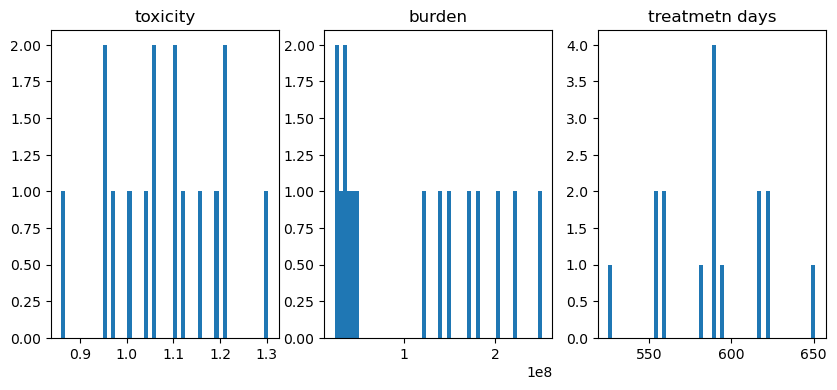

In [149]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");
ax[2].hist(df_sp["total_time"], bins=50)
ax[2].set_title("treatmetn days");

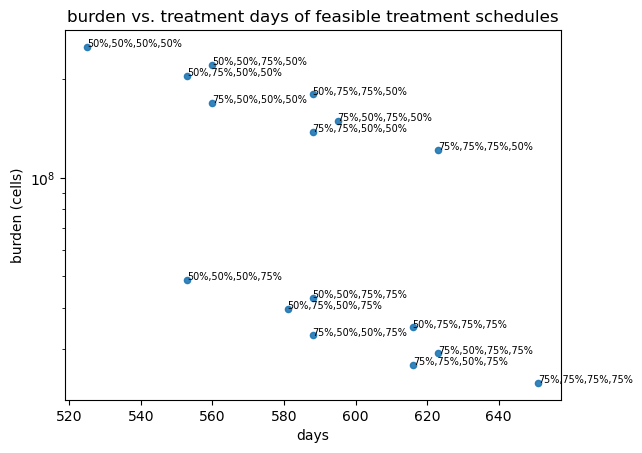

In [150]:
plt.scatter(df_sp["total_time"], df_sp["burden"], s=20, alpha=0.9)

# Add compact labels
for i in range(df_sp.shape[0]):
    values = df_sp.iloc[i][['S1','S2','S3','S4']].values
    label = f"{values[0]:2.0%},{values[1]:2.0%},{values[2]:2.0%},{values[3]:2.0%}"
    plt.text(df_sp.iloc[i]["total_time"], df_sp.iloc[i]["burden"], label, fontsize=7)

# set y to log
plt.yscale("log")
plt.xlabel("days")
plt.ylabel("burden (cells)")
plt.title("burden vs. treatment days of feasible treatment schedules");

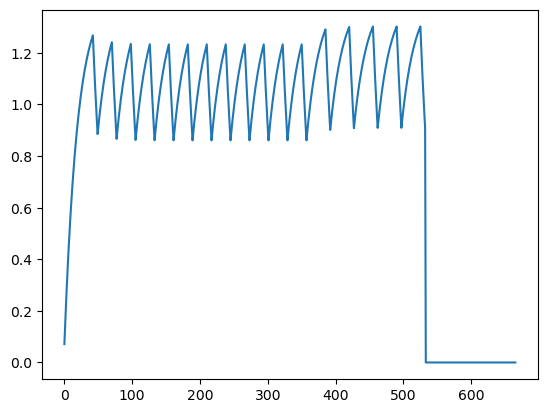

In [151]:
# select 
plt.plot(sols[i]["toxicity_sol"])

In [152]:
df_sp

,S1,S2,S3,S4,burden,toxicity,total_time
0,0.75,0.75,0.75,0.75,2.353517e+07,1.303077,651
1,0.75,0.75,0.75,0.50,1.216094e+08,1.152995,623
2,0.75,0.75,0.50,0.75,2.673937e+07,1.190746,616
3,0.75,0.75,0.50,0.50,1.381732e+08,1.040663,588
4,0.75,0.50,0.75,0.75,2.897292e+07,1.213212,623
5,0.75,0.50,0.75,0.50,1.497070e+08,1.063130,595
6,0.75,0.50,0.50,0.75,3.289276e+07,1.100881,588
7,0.75,0.50,0.50,0.50,1.699643e+08,0.950798,560
8,0.50,0.75,0.75,0.75,3.482151e+07,1.212142,616
9,0.50,0.75,0.75,0.50,1.799274e+08,1.062060,588


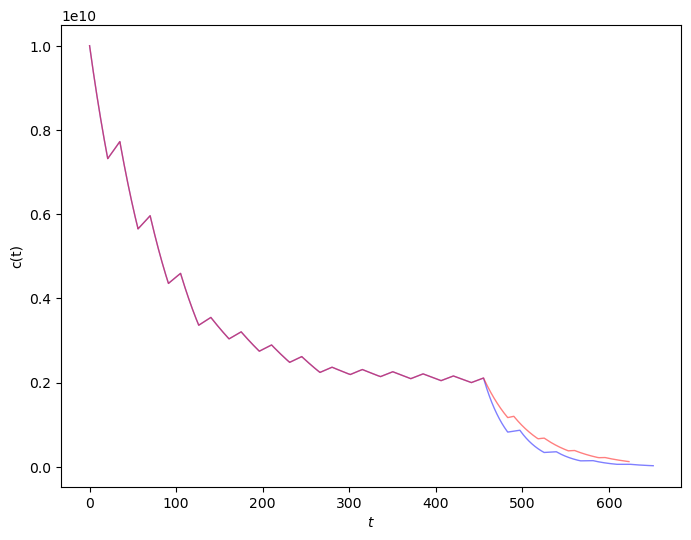

In [153]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("$t$")
ax.set_ylabel("c(t)")
sol = sols[0]["burden_sol"]
ax.plot(sol .t, sol .y.T[:, 0], color="blue", lw=1, alpha=0.5);
sol = sols[1]["burden_sol"]
ax.plot(sol .t, sol .y.T[:, 0], color="red", lw=1, alpha=0.5);